## Install Necessary Packages and Libraries

In [1]:
%pip install susie==1.2.2 -q


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys
sys.path.append("..")
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

# Importing from src imports directly from source code
from src.susie.timing_data import TimingData
from src.susie.ephemeris import Ephemeris, PrecessionModelEphemeris

import matplotlib.pyplot as plt

from lmfit import Model

## Import Data

In [3]:
url = "https://raw.githubusercontent.com/BoiseStatePlanetary/susie/refs/heads/main/example_data/wasp12b_tra_occ.csv"
data = pd.read_csv(url)
tra_or_occs = np.array(data["tra_or_occ"])
epochs = np.array(data["epoch"].astype('int'))
mid_times = np.array(data["mid_time"])
mid_time_errs = np.array(data["mid_time_err"])

### Plotting the Data

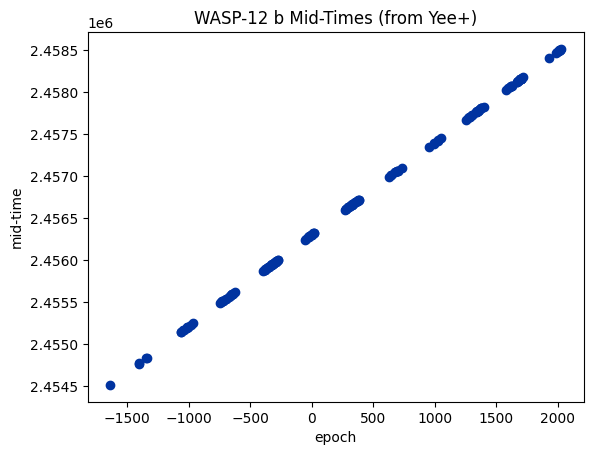

In [4]:
plt.scatter(epochs, mid_times, color="#0033A0")
plt.xlabel("epoch")
plt.ylabel("mid-time")
plt.title("WASP-12 b Mid-Times (from Yee+)")
plt.show()

## Helper Functions

In [35]:
def calc_anomalistic_period(P, dwdE):
    """Anomalistic Period Calculation (P_a)"""
    return P/(1 - ((1/(2*np.pi))*dwdE))

def calc_pericenter(w0, dwdE, E):
    """Pericenter Calculation (w(E))"""
    return w0 + dwdE*E

def precession_fit(E, T0, P, e, w0, dwdE, tra_or_occ):
    result = np.zeros(len(E))
    for i, t_type in enumerate(tra_or_occ):
        if t_type == 0:
            # transit data
            result[i] = T0 + (E[i]*P) - ((e*calc_anomalistic_period(P, dwdE))/np.pi)*np.cos(calc_pericenter(w0, dwdE, E[i]))
        elif t_type == 1:
            # occultation data
            result[i] = T0 + calc_anomalistic_period(P, dwdE)/2 + (E[i]*P) + ((e*calc_anomalistic_period(P, dwdE))/np.pi)*np.cos(calc_pericenter(w0, dwdE, E[i]))
    return result

def calc_precession_model(E, T0, P, e, w0, dwdE, tra_or_occ):
    result = np.zeros(len(E))
    for i, t_type in enumerate(tra_or_occ):
        if t_type == 0:
            # transit data
            result[i] = T0 + (E[i]*P) - ((e*calc_anomalistic_period(P, dwdE))/np.pi)*np.cos(calc_pericenter(w0, dwdE, E[i]))
        elif t_type == 1:
            # occultation data
            result[i] = T0 + calc_anomalistic_period(P, dwdE)/2 + (E[i]*P) + ((e*calc_anomalistic_period(P, dwdE))/np.pi)*np.cos(calc_pericenter(w0, dwdE, E[i]))
    return result

def return_precession_dict(lmfit_result):
    return_data = {
        'period': lmfit_result.params['P'].value,
        'period_err': lmfit_result.params['P'].stderr,
        'conjunction_time': lmfit_result.params['T0'].value,
        'conjunction_time_err': lmfit_result.params['T0'].stderr,
        'eccentricity': lmfit_result.params['e'].value,
        'eccentricity_err': lmfit_result.params['e'].stderr,
        'pericenter': lmfit_result.params['w0'].value,
        'pericenter_err': lmfit_result.params['w0'].stderr,
        'pericenter_change_by_epoch': lmfit_result.params['dwdE'].value,
        'pericenter_change_by_epoch_err': lmfit_result.params['dwdE'].stderr
    }
    return return_data

def fit_precession_model(epochs, mid_times, mid_time_errs, tra_or_occ):
    # STARTING VAL OF dwdE CANNOT BE 0, WILL RESULT IN NAN VALUES FOR THE MODEL
    tra_or_occ_enum = [0 if i == 'tra' else 1 for i in tra_or_occ]
    model = Model(precession_fit, independent_vars=['E', 'tra_or_occ'])
    params = model.make_params(T0=0.0, P=1.091423, dwdE=dict(value=0.000984), e=dict(value=0.00310, min=0, max=1), w0=2.62, tra_or_occ=tra_or_occ_enum)
    result = model.fit(mid_times, params, weights=1.0/mid_time_errs, E=epochs, tra_or_occ=tra_or_occ_enum)
    return_data = return_precession_dict(result)
    return(return_data)

def calc_precession_model_tra(E, T0, P, e, w0, dwdE):
    return T0 + (E*P) - ((e*calc_anomalistic_period(P, dwdE))/np.pi)*np.cos(calc_pericenter(w0, dwdE, E))

def calc_precession_model_occ(E, T0, P, e, w0, dwdE):
    return T0 + calc_anomalistic_period(P, dwdE)/2 + (E*P) + ((e*calc_anomalistic_period(P, dwdE))/np.pi)*np.cos(calc_pericenter(w0, dwdE, E))

def subtract_linear_params(model_mid_times, T0, P, E, tra_or_occ):
    """Subtracting Linear Parameters From Given Mid-Times Function"""
    result = []
    for i, t_type in enumerate(tra_or_occ):
        if t_type == 'tra':
            # transit data
            result.append(model_mid_times[i] - T0 - (P*E[i]))
        elif t_type == 'occ':
            # occultation data
            result.append(model_mid_times[i] - T0 - (0.5*P) - (P*E[i]))
    return np.array(result)

def plot_model_ephemeris(ephemeris_obj, model_data_dict, subtract_lin_params=False, show_occultations=False):
    """Plot Model Ephemeris Function"""
    fig, ax = plt.subplots(figsize=(6, 6))
    y_data = model_data_dict['model_data']
    if subtract_lin_params is True:
        y_data = subtract_linear_params(model_data_dict['model_data'], model_data_dict['conjunction_time'], model_data_dict['period'], ephemeris_obj.timing_data.epochs, ephemeris_obj.timing_data.tra_or_occ) * 86400
    ax.scatter(x=ephemeris_obj.timing_data.epochs, y=y_data, color='#0033A0', zorder=10, label="Transits")
    if show_occultations is True:
        occ_mask = ephemeris_obj.timing_data.tra_or_occ == "occ"
        occ_data = model_data_dict["model_data"][occ_mask]
        if subtract_lin_params is True:
            occ_data = subtract_linear_params(occ_data, model_data_dict['conjunction_time'], model_data_dict['period'], ephemeris_obj.timing_data.epochs[occ_mask], ephemeris_obj.timing_data.tra_or_occ[occ_mask]) * 86400
        ax.scatter(x=ephemeris_obj.timing_data.epochs[occ_mask], y=occ_data, color="#D64309", zorder=20, label="Occultations")
        ax.legend()
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Mid-Times (JD TDB)')
    ax.set_title(f'{model_data_dict["model_type"].capitalize()} Model Ephemeris Mid-Times')
    ax.grid(linestyle='--', linewidth=0.25, zorder=-1)
    ax.ticklabel_format(style="plain", useOffset=False)
    return ax

def plot_oc_plot(ephemeris_obj, model, T0, P):
    """O-C Plot Function"""
    fig, ax = plt.subplots()
    DAYS_TO_SECONDS = 86400
    model_data = ephemeris_obj.get_model_ephemeris(model)
    y = (subtract_linear_params(ephemeris_obj.timing_data.mid_times, T0, P, ephemeris_obj.timing_data.epochs, ephemeris_obj.timing_data.tra_or_occ)) * DAYS_TO_SECONDS
    ax.errorbar(ephemeris_obj.timing_data.epochs, y, yerr=ephemeris_obj.timing_data.mid_time_uncertainties*DAYS_TO_SECONDS, 
                marker='o', ls='', color='#0033A0',
                label=r'$t(E) - T_0 - P E$')
    if model == "quadratic":
        # Plot additional quadratic curve
        quad_model_curve = (0.5*model_data['period_change_by_epoch'])*((ephemeris_obj.timing_data.epochs - np.median(ephemeris_obj.timing_data.epochs))**2) * DAYS_TO_SECONDS
        ax.plot(ephemeris_obj.timing_data.epochs,
                (quad_model_curve),
                color='#D64309', ls="--", label=r'$\frac{1}{2}(\frac{dP}{dE})E^2$')
    if model == "precession":
        # Plot additional precession curves
        tra_mask = ephemeris_obj.timing_data.tra_or_occ == "tra"
        occ_mask = ephemeris_obj.timing_data.tra_or_occ == "occ"
        # tra curve = -1 * (e*P_a)/(pi) * cos(w(E))
        # occ curve = (e*P_a)/(pi) * cos(w(E))
        precession_model_curve_tra = (-1 * ((model_data["eccentricity"]*calc_anomalistic_period(P, model_data["pericenter_change_by_epoch"]))/np.pi) * np.cos(calc_pericenter(model_data["pericenter"], model_data["pericenter_change_by_epoch"], (ephemeris_obj.timing_data.epochs[tra_mask] - np.median(ephemeris_obj.timing_data.epochs[tra_mask]))))) * DAYS_TO_SECONDS
        precession_model_curve_occ = (((model_data["eccentricity"]*calc_anomalistic_period(P, model_data["pericenter_change_by_epoch"]))/np.pi) * np.cos(calc_pericenter(model_data["pericenter"], model_data["pericenter_change_by_epoch"], (ephemeris_obj.timing_data.epochs[occ_mask] - np.median(ephemeris_obj.timing_data.epochs[occ_mask]))))) * DAYS_TO_SECONDS
        ax.plot(ephemeris_obj.timing_data.epochs[tra_mask],
                (precession_model_curve_tra),
                color='#D64309', ls="--", label=r'$-\frac{eP_a}{\pi}\cos\omega(E)$')
        ax.plot(ephemeris_obj.timing_data.epochs[occ_mask],
                (precession_model_curve_occ),
                color='#D64309', ls=":", label=r'$\frac{eP_a}{\pi}\cos\omega(E)$')
    ax.legend()
    ax.set_xlabel('Epoch')
    ax.set_ylabel('O-C (seconds)')
    ax.set_title('Observed Minus Calculated Mid-Times')
    ax.grid(linestyle='--', linewidth=0.25, zorder=-1)
    return ax

## Create Susie Objects

In [6]:
# Create new transit times object with above data
timing_obj = TimingData('jd', epochs, mid_times, mid_time_uncertainties=mid_time_errs, tra_or_occ=tra_or_occs, time_scale='tdb')
ephemeris_obj = Ephemeris(timing_obj)

In [7]:
# MODELS
lin_model = ephemeris_obj.get_model_ephemeris("linear")
quad_model = ephemeris_obj.get_model_ephemeris("quadratic")
prec_model = ephemeris_obj.get_model_ephemeris("precession")

## Plotting O-C and Comparing to Yee+

### Linear Model

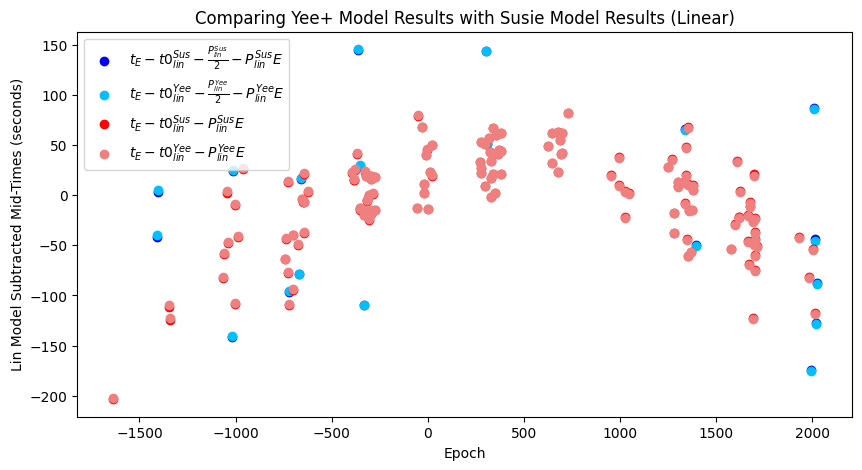

In [8]:
plt.figure(figsize=(10, 5))

tra_mask = tra_or_occs == 'tra'
occ_mask = tra_or_occs == 'occ'

plt.scatter(epochs[occ_mask], (mid_times[occ_mask] - (lin_model["conjunction_time"] + (lin_model["period"]/2) + (lin_model["period"]*epochs[occ_mask])))*24*60*60, color="blue", label=r"$t_E - t0_{lin}^{Sus} - \frac{P_{lin}^{Sus}}{2} - P_{lin}^{Sus}E$")
plt.scatter(epochs[occ_mask], (mid_times[occ_mask] - (2456305.455521 + (1.091419649/2) + (1.091419649*epochs[occ_mask])))*24*60*60, color="deepskyblue", label=r"$t_E - t0_{lin}^{Yee} - \frac{P_{lin}^{Yee}}{2} - P_{lin}^{Yee}E$")

plt.scatter(epochs[tra_mask], (mid_times[tra_mask] - (lin_model["conjunction_time"] + lin_model["period"]*epochs[tra_mask]))*24*60*60, color="red", label=r"$t_E - t0_{lin}^{Sus} - P_{lin}^{Sus}E$")
plt.scatter(epochs[tra_mask], (mid_times[tra_mask] - (2456305.455521 + 1.091419649*epochs[tra_mask]))*24*60*60, color="lightcoral", label=r"$t_E - t0_{lin}^{Yee} - P_{lin}^{Yee}E$")

plt.title("Comparing Yee+ Model Results with Susie Model Results (Linear)")
plt.xlabel("Epoch")
plt.ylabel("Lin Model Subtracted Mid-Times (seconds)")
plt.legend()
plt.show()

### Quadratic Model

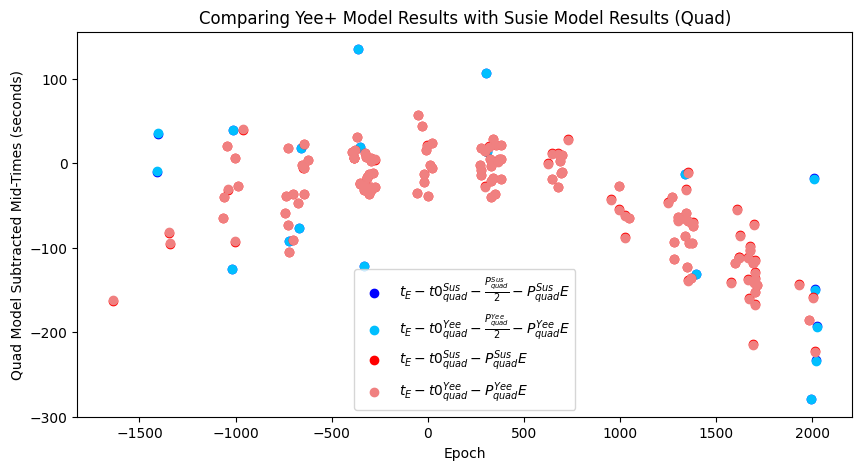

In [9]:
plt.figure(figsize=(10, 5))

tra_mask = tra_or_occs == 'tra'
occ_mask = tra_or_occs == 'occ'

plt.scatter(epochs[occ_mask], (mid_times[occ_mask] - (quad_model["conjunction_time"] + (quad_model["period"]/2) + (quad_model["period"]*epochs[occ_mask])))*24*60*60, color="blue", label=r"$t_E - t0_{quad}^{Sus} - \frac{P_{quad}^{Sus}}{2} - P_{quad}^{Sus}E$")
# plt.scatter(epochs[occ_mask], (mid_times[occ_mask] - (2456305.455521 + (1.091419649/2) + (1.091419649*epochs[occ_mask])))*24*60*60, color="deepskyblue", label=r"$t_E - t0_{lin}^{Yee} - \frac{P_{lin}^{Yee}}{2} - P_{lin}^{Yee}E$")
plt.scatter(epochs[occ_mask], (mid_times[occ_mask] - (2456305.455809 + (1.091420107/2) + (1.091420107*epochs[occ_mask])))*24*60*60, color="deepskyblue", label=r"$t_E - t0_{quad}^{Yee} - \frac{P_{quad}^{Yee}}{2} - P_{quad}^{Yee}E$")

plt.scatter(epochs[tra_mask], (mid_times[tra_mask] - (quad_model["conjunction_time"] + quad_model["period"]*epochs[tra_mask]))*24*60*60, color="red", label=r"$t_E - t0_{quad}^{Sus} - P_{quad}^{Sus}E$")
# plt.scatter(epochs[tra_mask], (mid_times[tra_mask] - (2456305.455521 + 1.091419649*epochs[tra_mask]))*24*60*60, color="lightcoral", label=r"$t_E - t0_{lin}^{Yee} - P_{lin}^{Yee}E$")
plt.scatter(epochs[tra_mask], (mid_times[tra_mask] - (2456305.455809 + 1.091420107*epochs[tra_mask]))*24*60*60, color="lightcoral", label=r"$t_E - t0_{quad}^{Yee} - P_{quad}^{Yee}E$")

plt.title("Comparing Yee+ Model Results with Susie Model Results (Quad)")
plt.xlabel("Epoch")
plt.ylabel("Quad Model Subtracted Mid-Times (seconds)")
plt.legend()
plt.show()

### Precession Model

Precession Model Best Fit Parameters of Susie Model and Yee+ Model
|    | Susie | Yee+ | Diff |
| -- | ----- | ---- | ---- |
|  P | 1.0914194082945827 | 1.091419633 | -2.247054171622409e-07 |
| T0 | 2456305.4612811077 | 2456305.45488 | 0.006401107646524906 |
|  e | 0.9952509910870059 | 0.00310 | 0.9921509910870059 |
| w  | 18110693.459108967 | 2.62 | 18110690.839108966 |
|dwdE| -53113.28578976777 | 0.000984 | -53113.286773767766 |

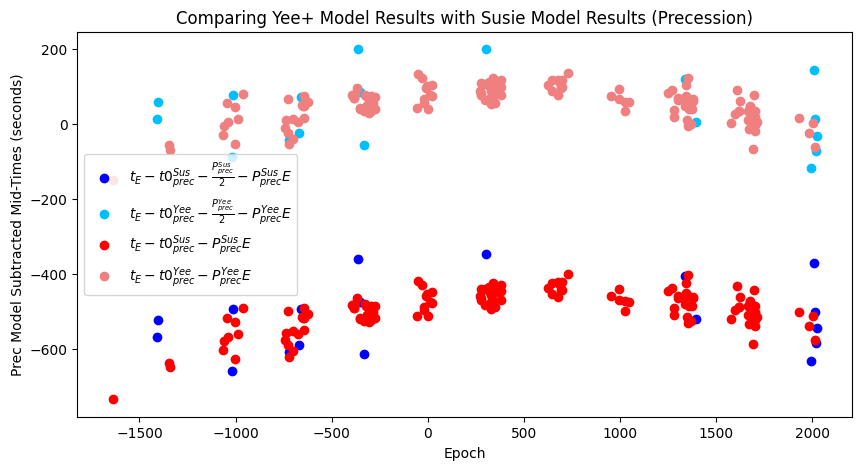

In [10]:
plt.figure(figsize=(10, 5))

tra_mask = tra_or_occs == 'tra'
occ_mask = tra_or_occs == 'occ'

plt.scatter(epochs[occ_mask], (mid_times[occ_mask] - (prec_model["conjunction_time"] + (prec_model["period"]/2) + (prec_model["period"]*epochs[occ_mask])))*24*60*60, color="blue", label=r"$t_E - t0_{prec}^{Sus} - \frac{P_{prec}^{Sus}}{2} - P_{prec}^{Sus}E$")
# plt.scatter(epochs[occ_mask], (mid_times[occ_mask] - (2456305.455521 + (1.091419649/2) + (1.091419649*epochs[occ_mask])))*24*60*60, color="deepskyblue", label=r"$t_E - t0_{lin}^{Yee} - \frac{P_{lin}^{Yee}}{2} - P_{lin}^{Yee}E$")
plt.scatter(epochs[occ_mask], (mid_times[occ_mask] - (2456305.45488 + (1.091419633/2) + (1.091419633*epochs[occ_mask])))*24*60*60, color="deepskyblue", label=r"$t_E - t0_{prec}^{Yee} - \frac{P_{prec}^{Yee}}{2} - P_{prec}^{Yee}E$")

plt.scatter(epochs[tra_mask], (mid_times[tra_mask] - (prec_model["conjunction_time"] + prec_model["period"]*epochs[tra_mask]))*24*60*60, color="red", label=r"$t_E - t0_{prec}^{Sus} - P_{prec}^{Sus}E$")
# plt.scatter(epochs[tra_mask], (mid_times[tra_mask] - (2456305.455521 + 1.091419649*epochs[tra_mask]))*24*60*60, color="lightcoral", label=r"$t_E - t0_{lin}^{Yee} - P_{lin}^{Yee}E$")
plt.scatter(epochs[tra_mask], (mid_times[tra_mask] - (2456305.45488 + 1.091419633*epochs[tra_mask]))*24*60*60, color="lightcoral", label=r"$t_E - t0_{prec}^{Yee} - P_{prec}^{Yee}E$")

plt.title("Comparing Yee+ Model Results with Susie Model Results (Precession)")
plt.xlabel("Epoch")
plt.ylabel("Prec Model Subtracted Mid-Times (seconds)")
plt.legend()
plt.show()

In [11]:
# Note: The difference in T0 reflects the same difference in the distance between points on the O-C plot below (~553 seconds)
susie_tra_oc = ((mid_times[tra_mask] - (prec_model["conjunction_time"] + prec_model["period"]*epochs[tra_mask]))*24*60*60)
yee_tra_oc = ((mid_times[tra_mask] - (2456305.45488 + 1.091419633*epochs[tra_mask]))*24*60*60)

susie_occ_oc = ((mid_times[occ_mask] - (prec_model["conjunction_time"] + prec_model["period"]*epochs[occ_mask]))*24*60*60)
yee_occ_oc = ((mid_times[occ_mask] - (2456305.45488 + 1.091419633*epochs[occ_mask]))*24*60*60)

print(f"Difference in Susie T0 and Yee T0 (seconds): {0.006401107646524906*24*60*60}\nAverage difference in Susie precession model calculated transits and Yee model calculated transits: {abs(np.average(susie_tra_oc - yee_tra_oc))}\nAverage difference in Susie precession model calculated occultations and Yee model calculated occultations: {abs(np.average(susie_occ_oc - yee_occ_oc))}")


Difference in Susie T0 and Yee T0 (seconds): 553.0557006597519
Average difference in Susie precession model calculated transits and Yee model calculated transits: 544.9552246027713
Average difference in Susie precession model calculated occultations and Yee model calculated occultations: 547.4500052238766


Note: At this point, realized there was something wrong with the precession model. Let's double check the Susie code.

<hr>

## Precession Model Plotting Exploration

### Plotting the Precession Model Curves Using Yee+ Parameters

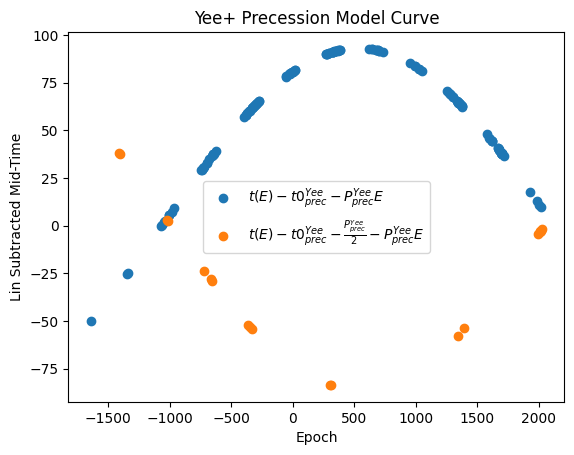

In [12]:
precession_curve_tra_yee = 2456305.45488 + (epochs[tra_mask]*1.091419633) - ((0.00310*calc_anomalistic_period(1.091419633, 0.000984))/np.pi)*np.cos(calc_pericenter(2.62, 0.000984, epochs[tra_mask]))
precession_curve_occ_yee = 2456305.45488 + calc_anomalistic_period(1.091419633, 0.000984)/2 + (epochs[occ_mask]*1.091419633) + ((0.00310*calc_anomalistic_period(1.091419633, 0.000984))/np.pi)*np.cos(calc_pericenter(2.62, 0.000984, epochs[occ_mask]))

plt.scatter(epochs[tra_mask], (precession_curve_tra_yee - 2456305.45488 - (epochs[tra_mask]*1.091419633))*24*60*60, label=r"$t(E) - t0_{prec}^{Yee} - P_{prec}^{Yee}E$")
plt.scatter(epochs[occ_mask], (precession_curve_occ_yee - 2456305.45488 - (1.091419633/2) - (epochs[occ_mask]*1.091419633))*24*60*60, label=r"$t(E) - t0_{prec}^{Yee} - \frac{P_{prec}^{Yee}}{2} - P_{prec}^{Yee}E$")

plt.xlabel("Epoch")
plt.ylabel("Lin Subtracted Mid-Time")
plt.legend()
plt.title("Yee+ Precession Model Curve")
plt.show()

### Plotting the Precession Model Curves Using Susie Parameters

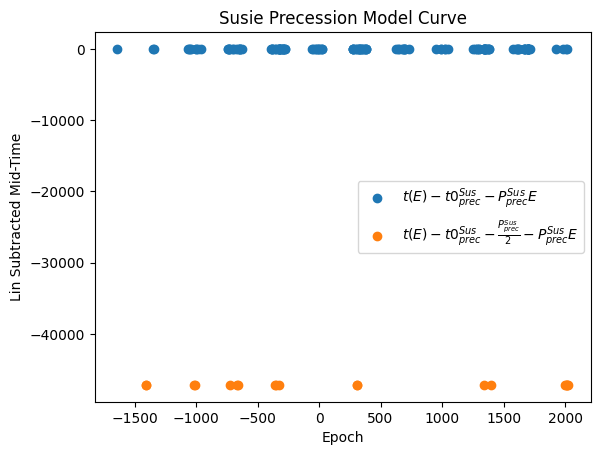

In [13]:
# Note: hard coded to minimize mix-ups/bugs
precession_curve_tra_susie = 2456305.4612811077 + (epochs[tra_mask]*1.0914194082945827) - ((0.9952509910870059*calc_anomalistic_period(1.0914194082945827, -53113.28578976777))/np.pi)*np.cos(calc_pericenter(18110693.459108967, -53113.28578976777, epochs[tra_mask]))
precession_curve_occ_susie = 2456305.4612811077 + calc_anomalistic_period(1.0914194082945827, -53113.28578976777)/2 + (epochs[occ_mask]*1.0914194082945827) + ((0.9952509910870059*calc_anomalistic_period(1.0914194082945827, -53113.28578976777))/np.pi)*np.cos(calc_pericenter(18110693.459108967, -53113.28578976777, epochs[occ_mask]))

plt.scatter(epochs[tra_mask], (precession_curve_tra_susie - 2456305.4612811077 - (epochs[tra_mask]*1.0914194082945827))*24*60*60, label=r"$t(E) - t0_{prec}^{Sus} - P_{prec}^{Sus}E$")
plt.scatter(epochs[occ_mask], (precession_curve_occ_susie - 2456305.4612811077 - (1.0914194082945827/2) - (epochs[occ_mask]*1.0914194082945827))*24*60*60, label=r"$t(E) - t0_{prec}^{Sus} - \frac{P_{prec}^{Sus}}{2} - P_{prec}^{Sus}E$")

plt.xlabel("Epoch")
plt.ylabel("Lin Subtracted Mid-Time")
plt.legend()
plt.title("Susie Precession Model Curve")
plt.show()

Obviously something is wrong with how LMFit is fitting to this data. The best fit parameters being returned do not work.

Let's look into LMFit some more.

<hr>

## Testing equations

Testing to see that each equation returns what is expected. Using the following data points:

|tra_or_occ|mid_time|mid_time_err|epoch|
| -- | -- | -- | -- |
|tra|2454515.52496|0.00043|-1640|
|occ|2454769.28190|0.00080|-1408|

Assuming Yee+ values for best-fit params:

| P | T0 | e | w | dwdE |
| -- | -- | -- | -- | -- |
|1.091419633|2456305.45488|0.00310|2.62|0.000984|

**Transit**

|  | Hand-calc value | Code-calc value | Diff | Notes |
| -- | -- | -- | -- | -- |
| Anomalistic Period | 1.091590585 | 1.091590585324887 | 3.2488700618671373e-10 | Only machine differences |
| Pericenter | 1.00624 | 1.00624 | 0 | -- |
| Model mid-time | 2454515.526 | 2454515.5261055664 | 0.0001055663451552391 | Only machine differences  |

**Occultation**

|  | Hand-calc value | Code-calc value | Diff | Notes |
| -- | -- | -- | -- | -- |
| Anomalistic Period | 1.091590585 | 1.091590585324887 | 3.2488700618671373e-10 | Only machine differences |
| Pericenter | 1.234528 | 1.234528 | 0 | -- |
| Model mid-time | 2454769.282 | 2454769.2821874483 | 0.00018744822591543198 | Only machine differences  |

All equations are returning what is expected, so that is not the problem.

Let's look into the LMFit Model.

<hr>

## LMFit Model Exploration

Let's isolate the transit and occultation fits so we can test them separately.

### Exploring Transits

In [68]:
def precession_fit_tra_only(E, T0, P, e, w0, dwdE):
    return T0 + (E*P) - ((e*calc_anomalistic_period(P, dwdE))/np.pi)*np.cos(calc_pericenter(w0, dwdE, E))

def fit_model_tra_only_result_return(epochs, mid_times, mid_time_errs):
    model = Model(precession_fit_tra_only, independent_vars=['E'])
    params = model.make_params(T0=dict(value=2e6), P=dict(value=1.0), e=dict(value=0.01), w0=dict(value=2.7), dwdE=dict(value=1e-3))
    result = model.fit(mid_times, params, weights=1.0/mid_time_errs, E=epochs)
    # return_data = return_precession_dict(result)
    # return(return_data)
    return result

In [69]:
prec_tra_only_result = fit_model_tra_only_result_return(epochs[tra_mask], mid_times[tra_mask], mid_time_errs[tra_mask])
print(prec_tra_only_result.fit_report())

[[Model]]
    Model(precession_fit_tra_only)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 139
    # variables        = 5
    chi-square         = 216.257175
    reduced chi-square = 1.61385952
    Akaike info crit   = 71.4372206
    Bayesian info crit = 86.1095902
    R-squared          = 1.00000000
[[Variables]]
    T0:    2456305.45 +/- 0.00364901 (0.00%) (init = 2000000)
    P:     1.09141925 +/- 9.1509e-07 (0.00%) (init = 1)
    e:     0.00871199 +/- 0.01178270 (135.25%) (init = 0.01)
    w0:    2.68959027 +/- 0.34742378 (12.92%) (init = 2.7)
    dwdE:  6.5370e-04 +/- 4.6416e-04 (71.00%) (init = 0.001)
[[Correlations]] (unreported correlations are < 0.100)
    C(T0, dwdE) = +0.9967
    C(e, dwdE)  = -0.9965
    C(T0, e)    = -0.9926
    C(P, w0)    = +0.7633
    C(P, e)     = -0.7601
    C(P, dwdE)  = +0.7199
    C(T0, P)    = +0.6761
    C(e, w0)    = -0.1623
    C(w0, dwdE) = +0.1032


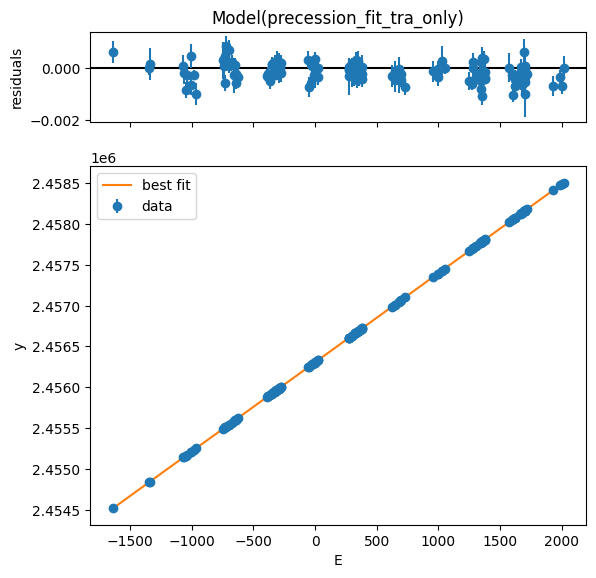

In [72]:
prec_tra_only_result.plot()
plt.show()

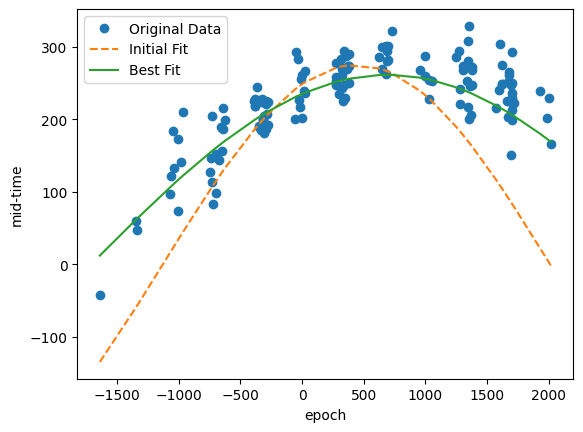

In [71]:
plt.plot(epochs[tra_mask], (mid_times[tra_mask] - prec_tra_only_result.params["T0"].value - (prec_tra_only_result.params["P"].value*epochs[tra_mask]))*24*60*60, "o", label="Original Data")
plt.plot(epochs[tra_mask], (prec_tra_only_result.init_fit - prec_tra_only_result.params["T0"].init_value - (prec_tra_only_result.params["P"].init_value*epochs[tra_mask]))*24*60*60, "--", label="Initial Fit")
plt.plot(epochs[tra_mask], (prec_tra_only_result.best_fit - prec_tra_only_result.params["T0"].value - (prec_tra_only_result.params["P"].value*epochs[tra_mask]))*24*60*60, "-", label="Best Fit")
plt.xlabel("epoch")
plt.ylabel("mid-time")
plt.legend()
plt.show()

### Exploring Occultations

In [80]:
def precession_fit_occ_only(E, T0, P, e, w0, dwdE):
    return T0 + calc_anomalistic_period(P, dwdE)/2 + (E*P) + ((e*calc_anomalistic_period(P, dwdE))/np.pi)*np.cos(calc_pericenter(w0, dwdE, E))

def fit_model_occ_only_result_return(epochs, mid_times, mid_time_errs):
    model = Model(precession_fit_occ_only, independent_vars=['E'])
    params = model.make_params(T0=dict(value=2e6), P=dict(value=1.0), e=dict(value=0.01), w0=dict(value=2.7), dwdE=dict(value=1e-3))
    result = model.fit(mid_times, params, weights=1.0/mid_time_errs, E=epochs)
    # return_data = return_precession_dict(result)
    # return(return_data)
    return result

In [81]:
prec_occ_only_result = fit_model_occ_only_result_return(epochs[occ_mask], mid_times[occ_mask], mid_time_errs[occ_mask])
print(prec_occ_only_result.fit_report())

[[Model]]
    Model(precession_fit_occ_only)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 19
    # variables        = 5
    chi-square         = 235.756361
    reduced chi-square = 16.8397401
    Akaike info crit   = 57.8488386
    Bayesian info crit = 62.5710335
    R-squared          = 1.00000000
[[Variables]]
    T0:    2456305.46 +/- 0.01122502 (0.00%) (init = 2000000)
    P:     1.09141948 +/- 3.8359e-06 (0.00%) (init = 1)
    e:     0.00864929 +/- 0.02990451 (345.75%) (init = 0.01)
    w0:    3.38427116 +/- 0.59836817 (17.68%) (init = 2.7)
    dwdE: -7.2975e-04 +/- 0.00114513 (156.92%) (init = 0.001)
[[Correlations]] (unreported correlations are < 0.100)
    C(T0, dwdE) = +0.9889
    C(e, dwdE)  = +0.9759
    C(T0, e)    = +0.9509
    C(P, w0)    = +0.7061
    C(P, e)     = +0.6164
    C(P, dwdE)  = +0.5515
    C(T0, P)    = +0.4445
    C(T0, w0)   = -0.2917
    C(w0, dwdE) = -0.1761


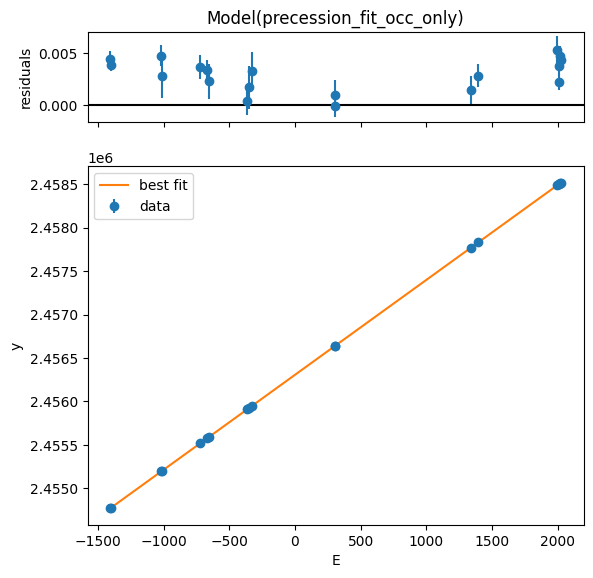

In [83]:
prec_occ_only_result.plot()
plt.show()

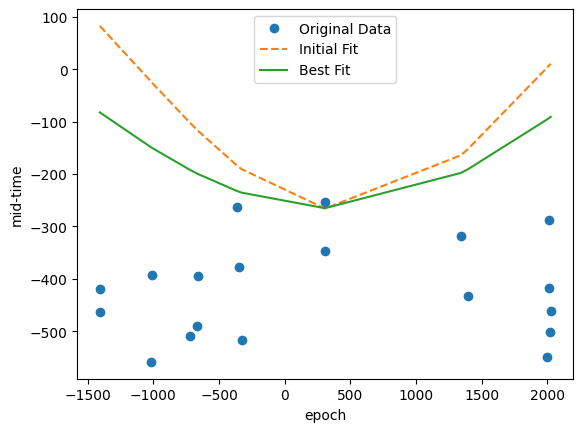

In [82]:
plt.plot(epochs[occ_mask], (mid_times[occ_mask] - prec_occ_only_result.params["T0"].value - (prec_occ_only_result.params["P"].value/2) - (prec_occ_only_result.params["P"].value*epochs[occ_mask]))*24*60*60, "o", label="Original Data")
plt.plot(epochs[occ_mask], (prec_occ_only_result.init_fit - prec_occ_only_result.params["T0"].init_value - (prec_occ_only_result.params["P"].init_value/2) - (prec_occ_only_result.params["P"].init_value*epochs[occ_mask]))*24*60*60, "--", label="Initial Fit", color="tab:orange")
plt.plot(epochs[occ_mask], (prec_occ_only_result.best_fit - prec_occ_only_result.params["T0"].value - (prec_occ_only_result.params["P"].value/2) - (prec_occ_only_result.params["P"].value*epochs[occ_mask]))*24*60*60, "-", label="Best Fit", color="tab:green")
plt.xlabel("epoch")
plt.ylabel("mid-time")
plt.legend()
plt.show()

### Trying with bounds on most parameters

Transits

In [84]:
def fit_model_tra_only_result_return_bounds(epochs, mid_times, mid_time_errs):
    model = Model(precession_fit_tra_only, independent_vars=['E'])
    params = model.make_params(T0=dict(value=2e6), P=dict(value=1.0), e=dict(value=0.01, min=0, max=1), w0=dict(value=2.7, min=-100, max=100), dwdE=dict(value=1e-3, min=-1, max=1))
    result = model.fit(mid_times, params, weights=1.0/mid_time_errs, E=epochs)
    return result

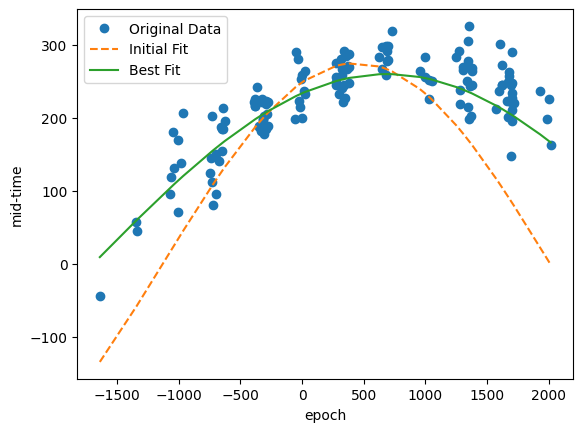

In [88]:
prec_tra_only_result_bounds = fit_model_tra_only_result_return_bounds(epochs[tra_mask], mid_times[tra_mask], mid_time_errs[tra_mask])
plt.plot(epochs[tra_mask], (mid_times[tra_mask] - prec_tra_only_result_bounds.params["T0"].value - (prec_tra_only_result_bounds.params["P"].value*epochs[tra_mask]))*24*60*60, "o", label="Original Data")
plt.plot(epochs[tra_mask], (prec_tra_only_result_bounds.init_fit - prec_tra_only_result_bounds.params["T0"].init_value - (prec_tra_only_result_bounds.params["P"].init_value*epochs[tra_mask]))*24*60*60, "--", label="Initial Fit")
plt.plot(epochs[tra_mask], (prec_tra_only_result_bounds.best_fit - prec_tra_only_result_bounds.params["T0"].value - (prec_tra_only_result_bounds.params["P"].value*epochs[tra_mask]))*24*60*60, "-", label="Best Fit")
plt.xlabel("epoch")
plt.ylabel("mid-time")
plt.legend()
plt.show()

Occultations

In [90]:
def fit_model_occ_only_result_return_bounds(epochs, mid_times, mid_time_errs):
    model = Model(precession_fit_occ_only, independent_vars=['E'])
    params = model.make_params(T0=dict(value=2e6), P=dict(value=1.0), e=dict(value=0.01, min=0, max=1), w0=dict(value=2.7, min=-100, max=100), dwdE=dict(value=1e-3, min=-1, max=1))
    result = model.fit(mid_times, params, weights=1.0/mid_time_errs, E=epochs)
    # return_data = return_precession_dict(result)
    # return(return_data)
    return result

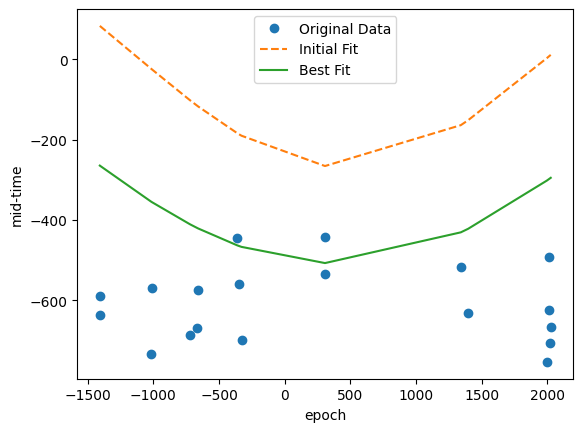

In [91]:
prec_occ_only_result_bounds = fit_model_occ_only_result_return_bounds(epochs[occ_mask], mid_times[occ_mask], mid_time_errs[occ_mask])
plt.plot(epochs[occ_mask], (mid_times[occ_mask] - prec_occ_only_result_bounds.params["T0"].value - (prec_occ_only_result_bounds.params["P"].value/2) - (prec_occ_only_result_bounds.params["P"].value*epochs[occ_mask]))*24*60*60, "o", label="Original Data")
plt.plot(epochs[occ_mask], (prec_occ_only_result_bounds.init_fit - prec_occ_only_result_bounds.params["T0"].init_value - (prec_occ_only_result_bounds.params["P"].init_value/2) - (prec_occ_only_result_bounds.params["P"].init_value*epochs[occ_mask]))*24*60*60, "--", label="Initial Fit", color="tab:orange")
plt.plot(epochs[occ_mask], (prec_occ_only_result_bounds.best_fit - prec_occ_only_result_bounds.params["T0"].value - (prec_occ_only_result_bounds.params["P"].value/2) - (prec_occ_only_result_bounds.params["P"].value*epochs[occ_mask]))*24*60*60, "-", label="Best Fit", color="tab:green")
plt.xlabel("epoch")
plt.ylabel("mid-time")
plt.legend()
plt.show()

### Trying with the method changed to "least_squares" instead of "lm"

In [94]:
def fit_model_tra_only_result_return_method_least_squares(epochs, mid_times, mid_time_errs):
    model = Model(precession_fit_tra_only, independent_vars=['E'])
    params = model.make_params(T0=dict(value=2e6), P=dict(value=1.0), e=dict(value=0.01, min=0, max=1), w0=dict(value=2.7, min=-100, max=100), dwdE=dict(value=1e-3, min=-1, max=1))
    result = model.fit(mid_times, params, weights=1.0/mid_time_errs, method="least_squares", E=epochs)
    return result

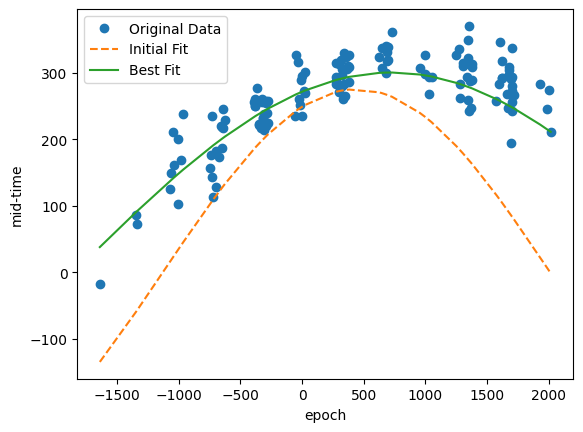

In [95]:
prec_tra_only_result_method_least_squares = fit_model_tra_only_result_return_method_least_squares(epochs[tra_mask], mid_times[tra_mask], mid_time_errs[tra_mask])
plt.plot(epochs[tra_mask], (mid_times[tra_mask] - prec_tra_only_result_method_least_squares.params["T0"].value - (prec_tra_only_result_method_least_squares.params["P"].value*epochs[tra_mask]))*24*60*60, "o", label="Original Data")
plt.plot(epochs[tra_mask], (prec_tra_only_result_method_least_squares.init_fit - prec_tra_only_result_method_least_squares.params["T0"].init_value - (prec_tra_only_result_method_least_squares.params["P"].init_value*epochs[tra_mask]))*24*60*60, "--", label="Initial Fit")
plt.plot(epochs[tra_mask], (prec_tra_only_result_method_least_squares.best_fit - prec_tra_only_result_method_least_squares.params["T0"].value - (prec_tra_only_result_method_least_squares.params["P"].value*epochs[tra_mask]))*24*60*60, "-", label="Best Fit")
plt.xlabel("epoch")
plt.ylabel("mid-time")
plt.legend()
plt.show()

### Using entire function instead of splitting into transits and occultations

In [102]:
def fit_precession_model_bounds(epochs, mid_times, mid_time_errs, tra_or_occ):
    # STARTING VAL OF dwdE CANNOT BE 0, WILL RESULT IN NAN VALUES FOR THE MODEL
    tra_or_occ_enum = [0 if i == 'tra' else 1 for i in tra_or_occ]
    model = Model(precession_fit, independent_vars=['E', 'tra_or_occ'])
    params = model.make_params(T0=dict(value=2e6), P=dict(value=1.0), e=dict(value=0.01, min=0, max=1), w0=dict(value=2.7, min=-100, max=100), dwdE=dict(value=1e-3, min=-1, max=1), tra_or_occ=tra_or_occ_enum)
    result = model.fit(mid_times, params, weights=1.0/mid_time_errs, E=epochs, method="least_squares", tra_or_occ=tra_or_occ_enum)
    # return_data = return_precession_dict(result)
    # return(return_data)
    return result

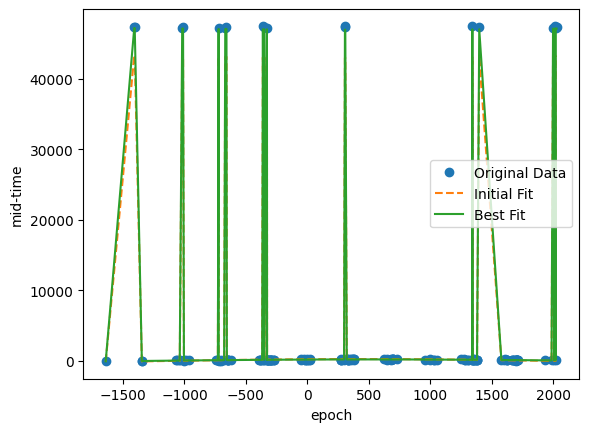

In [103]:
prec_result_bounds = fit_precession_model_bounds(epochs, mid_times, mid_time_errs, tra_or_occs)
plt.plot(epochs, (mid_times - prec_result_bounds.params["T0"].value - (prec_result_bounds.params["P"].value*epochs))*24*60*60, "o", label="Original Data")
plt.plot(epochs, (prec_result_bounds.init_fit - prec_result_bounds.params["T0"].init_value - (prec_result_bounds.params["P"].init_value*epochs))*24*60*60, "--", label="Initial Fit")
plt.plot(epochs, (prec_result_bounds.best_fit - prec_result_bounds.params["T0"].value - (prec_result_bounds.params["P"].value*epochs))*24*60*60, "-", label="Best Fit")
plt.xlabel("epoch")
plt.ylabel("mid-time")
plt.legend()
plt.show()

## Curve Fit

In [31]:
def precession_fit(E, T0, P, dwdE, w0, e, tra_or_occ):
    result = np.zeros(len(E))
    for i, t_type in enumerate(tra_or_occ):
        if t_type == 0:
            # transit data
            result[i] = T0 + (E[i]*P) - ((e*calc_anomalistic_period(P, dwdE))/np.pi)*np.cos(calc_pericenter(w0, dwdE, E[i]))
        elif t_type == 1:
            # occultation data
            result[i] = T0 + calc_anomalistic_period(P, dwdE)/2 + (E[i]*P) + ((e*calc_anomalistic_period(P, dwdE))/np.pi)*np.cos(calc_pericenter(w0, dwdE, E[i]))
    return result

def fit_model(epochs, mid_times, mid_time_errs, tra_or_occ):
    # STARTING VAL OF dwdE CANNOT BE 0, WILL RESULT IN NAN VALUES FOR THE MODEL
    tra_or_occ_enum = [0 if i == 'tra' else 1 for i in tra_or_occ]
    model = Model(precession_fit, independent_vars=['E', 'tra_or_occ'])
    params = model.make_params(T0=0.0, P=1.091423, dwdE=dict(value=0.000984), e=dict(value=0.00310, min=0, max=1), w0=2.62, tra_or_occ=tra_or_occ_enum)
    result = model.fit(mid_times, params, weights=1.0/mid_time_errs, E=epochs, tra_or_occ=tra_or_occ_enum)
    return_data = {
        'period': result.params['P'].value,
        'period_err': result.params['P'].stderr,
        'conjunction_time': result.params['T0'].value,
        'conjunction_time_err': result.params['T0'].stderr,
        'eccentricity': result.params['e'].value,
        'eccentricity_err': result.params['e'].stderr,
        'pericenter': result.params['w0'].value,
        'pericenter_err': result.params['w0'].stderr,
        'pericenter_change_by_epoch': result.params['dwdE'].value,
        'pericenter_change_by_epoch_err': result.params['dwdE'].stderr
    }
    return(return_data)

In [32]:
def calc_omega(N, omega_0, domega_dN):
    return omega_0 + domega_dN*N

def calc_Pa(Ps, domega_dN):
    return Ps/(1. - 1./2/np.pi*domega_dN)

def calc_ttra(N, T0, Ps, e, omega_0, domega_dN):
    omega = calc_omega(N, omega_0, domega_dN)
    Pa = calc_Pa(Ps, domega_dN)

    return T0 + N*Ps - e*Pa/np.pi*np.cos(omega)

def calc_tocc(N, T0, Ps, e, omega_0, domega_dN):
    omega = calc_omega(N, omega_0, domega_dN)
    Pa = calc_Pa(Ps, domega_dN)

    return T0 + Pa/2. + N*Ps + e*Pa/np.pi*np.cos(omega)

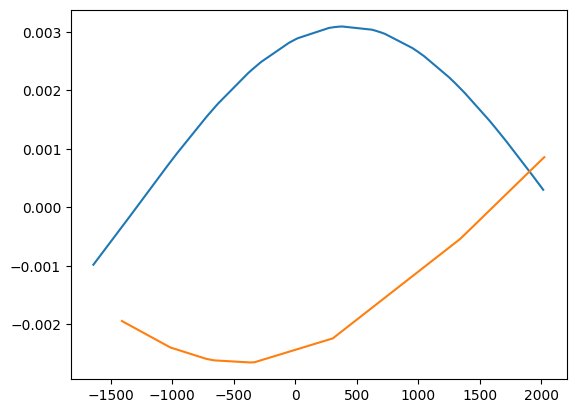

In [33]:
def precession_curve_fit(E, T0, P, e, w0, dwdE, tra_or_occ):
    result = np.zeros(len(E))
    for i, t_type in enumerate(tra_or_occ):
        if t_type == 0:
            # transit data
            result[i] = T0 + (E[i]*P) - ((e*calc_anomalistic_period(P, dwdE))/np.pi)*np.cos(calc_pericenter(w0, dwdE, E[i]))
        elif t_type == 1:
            # occultation data
            result[i] = T0 + calc_anomalistic_period(P, dwdE)/2 + (E[i]*P) + ((e*calc_anomalistic_period(P, dwdE))/np.pi)*np.cos(calc_pericenter(w0, dwdE, E[i]))
    return result

def precession_curve_fit_tra(E, T0, P, e, w0, dwdE):
    return T0 + (E*P) - ((e*calc_anomalistic_period(P, dwdE))/np.pi)*np.cos(calc_pericenter(w0, dwdE, E))

def precession_curve_fit_occ(E, T0, P, e, w0, dwdE):
    return T0 + calc_anomalistic_period(P, dwdE)/2 + (E*P) + ((e*calc_anomalistic_period(P, dwdE))/np.pi)*np.cos(calc_pericenter(w0, dwdE, E))

init_T0 = 2e6
init_P = 1.
init_e = 0.01
init_w0 = 2.7
init_dwdE = 1e-3

popt_tra, pcov_tra = curve_fit(precession_curve_fit_tra, epochs[tra_mask], mid_times[tra_mask], sigma=mid_time_errs[tra_mask], p0=[init_T0, init_P, init_e, init_w0, init_dwdE], absolute_sigma=True)
popt_occ, pcov_occ = curve_fit(precession_curve_fit_occ, epochs[occ_mask], mid_times[occ_mask], sigma=mid_time_errs[occ_mask], p0=[init_T0, init_P, init_e, init_w0, init_dwdE], absolute_sigma=True)

model_T0_tra = popt_tra[0]
model_P_tra = popt_tra[1]
model_e_tra = popt_tra[2]
model_w0_tra = popt_tra[3]
model_dwdE_tra = popt_tra[4]

model_T0_occ = popt_occ[0]
model_P_occ = popt_occ[1]
model_e_occ = popt_occ[2]
model_w0_occ = popt_occ[3]
model_dwdE_occ = popt_occ[4]

plt.plot(epochs[tra_mask], calc_precession_model_tra(epochs[tra_mask], *popt_tra) - model_T0_tra - (model_P_tra*epochs[tra_mask]))
plt.plot(epochs[occ_mask], calc_precession_model_occ(epochs[occ_mask], *popt_occ) - model_T0_occ - (model_P_occ/2) - (model_P_occ*epochs[occ_mask]))
# plt.plot(epochs[tra_mask], calc_precession_model_tra(epochs[tra_mask], model_T0_tra, model_P_tra, model_e_tra, model_w0_tra, model_dwdE_tra) - model_T0_tra - (model_P_tra*epochs[tra_mask]))
unc = np.sqrt(np.diag(pcov_tra))
# print("Best-Fit T0, Ps, e, omega_0, domega_dN: ", popt)
# print("Unc on T0, Ps, e, omega_0, domega_dN: ", unc)
# print("Correct T0, Ps, e, omega_0, domega_dN: ", T0, Ps, e, omega_0, domega_dN)

plt.show()

In [34]:
popt_tra

array([2.45630545e+06, 1.09141978e+00, 8.90117751e-03, 2.75793401e+00,
       9.20982075e-04])